In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import pickle
import cv2
import math

In [8]:
def distance(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

class Maze:
    def __init__(self, maze_file_path="./maze_array.pkl"):
        with open(maze_file_path, 'rb') as f:
            loaded_arr = pickle.load(f)
        self.maze = loaded_arr
        self.rows, self.cols = self.maze.shape
        self.ends = [(row, col) for row in range(self.rows) for col in range(self.cols) if self.maze[row, col] == 3]
        self.start = (0, 0)  # 起点坐标
        self.end = None  # 终点坐标
        self.agent_pos = None  # 智能体当前位置
        self.entered_goal_area = False  # 是否进入过终点区域
        self.paved_area = []  # 记录走过的路径（终点内）
        self.step_cnt = 0
        self.max_steps = 500  # 最大步数
        
    def reset(self):
        self.agent_pos = self.start
        self.end = self.get_random_end()
        self.entered_goal_area = False
        self.paved_area = []
        self.step_cnt = 0
        return self.agent_pos
        
    def step(self, action):
        self.step_cnt += 1
        row, col = self.agent_pos
        
        
        done = False
        reach_end = False
        
        reward = -1
        if self.agent_pos not in self.ends:
            if action == 0:  # 上
                next_pos = (max(row - 1, 0), col)
            elif action == 1:  # 下
                next_pos = (min(row + 1, self.rows - 1), col)
                if self.rows - 5 >= next_pos[0]:
                    reward += 6
                else:
                    reward += 0
            elif action == 2:  # 左
                next_pos = (row, max(col - 1, 0))
            else:  # 右
                next_pos = (row, min(col + 1, self.cols - 1))
                reward += 3
        else:
            if action == 0:  # 上
                next_pos = (max(row - 1, 0), col)
            elif action == 1:  # 下
                next_pos = (min(row + 1, self.rows - 1), col)
            elif action == 2:  # 左
                next_pos = (row, max(col - 1, 0))
            else:  # 右
                next_pos = (row, min(col + 1, self.cols - 1))
            
        
        if self.maze[next_pos] == 1:  # 撞墙
            reward += -10
            next_pos = self.agent_pos
        
        elif self.maze[next_pos] == 2:  # 掉入悬崖
            reward += -80
            done = True
        
        elif next_pos not in self.ends:
            reward += -0.05*distance(self.agent_pos, self.end)  # 距离终点越近,惩罚越小
            
            if self.entered_goal_area:
                reward += -5  # 走出去了,惩罚 
        else:
            if not self.entered_goal_area:
                # 如果还没进入过终点区域,给予一次奖励并设置标志  
                reward += 500
                self.entered_goal_area = True
        
            if next_pos == self.end:  # 到达终点
                reward += 1000
                done = True
                reach_end = True

            elif next_pos in self.paved_area:
                pass  # 走了走过的路,小惩罚 
            else:
                reward += 1  # 积极探索,奖励
                self.paved_area.append(next_pos)
                
            
        
        if self.step_cnt >= self.max_steps:
            done = True
            
        if self.step_cnt % 20 == 0:
            self.end = self.get_random_end()
            self.paved_area = []
            
        self.agent_pos = next_pos
        
        return next_pos, reward, done, reach_end
    
    def get_random_end(self):
        return self.ends[np.random.randint(len(self.ends))]
    
    def render(self):
        print(self.agent_pos)

In [9]:
def train(maze, num_episodes, learning_rate, discount_factor, epsilon, max_steps):
    q_table = np.zeros((maze.rows * maze.cols, 4))  # 初始化Q表格
    episode_rewards = []  # 记录每个episode的累积奖励
    cnt = 0
    best_cnt = 0
    best_q_table = None
    
    for episode in range(num_episodes):
        state = maze.reset()
        state_idx = state[0] * maze.cols + state[1]  # 将状态坐标转换为Q表格的索引
        episode_reward = 0
        
        for step in range(max_steps):
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, 4)  # 随机选择动作
            else:
                action = np.argmax(q_table[state_idx])  # 根据Q表格选择最优动作
            
            next_state, reward, done, reach_end = maze.step(action)
            next_state_idx = next_state[0] * maze.cols + next_state[1]
            
            # Q-learning更新公式
            q_table[state_idx][action] += learning_rate * (reward + discount_factor * np.max(q_table[next_state_idx]) - q_table[state_idx][action]) 
            
            state_idx = next_state_idx
            episode_reward += reward
            
            if reach_end:
                # print("Happy!")
                cnt += 1
            
            if done:
                break
            
              
        episode_rewards.append(episode_reward)
        
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}: Average Reward = {np.mean(episode_rewards[-100:])} successful times: {cnt}")
            if cnt > best_cnt:
                best_cnt = cnt
                best_q_table = q_table.copy()
            cnt=0;        
        # 随着训练的进行,逐渐减小探索率
        if epsilon > 0.01:
            epsilon *= 0.99
        
    
    if best_q_table is None:
        best_q_table = q_table.copy()
        
    return best_q_table, episode_rewards

In [10]:
num_episodes = 10000
learning_rate = 0.1
discount_factor = 0.99
epsilon = 1.0
max_steps = 500

maze = Maze()
q_table, rewards = train(maze, num_episodes, learning_rate, discount_factor, epsilon, max_steps)


Episode 100: Average Reward = -44.06065883282579 successful times: 0
Episode 200: Average Reward = 275.2095397977782 successful times: 18
Episode 300: Average Reward = 444.3582266487625 successful times: 27
Episode 400: Average Reward = 675.4547027605716 successful times: 45
Episode 500: Average Reward = 612.3269949668785 successful times: 42
Episode 600: Average Reward = 572.4923998431356 successful times: 40
Episode 700: Average Reward = 719.0805687779592 successful times: 49
Episode 800: Average Reward = 662.4576091509084 successful times: 23
Episode 900: Average Reward = 733.78681618914 successful times: 30
Episode 1000: Average Reward = 703.1332369513765 successful times: 44
Episode 1100: Average Reward = 668.201133344194 successful times: 44
Episode 1200: Average Reward = 676.7687895210775 successful times: 38
Episode 1300: Average Reward = 744.2767294577557 successful times: 9
Episode 1400: Average Reward = 871.2472851381009 successful times: 19
Episode 1500: Average Reward = 67

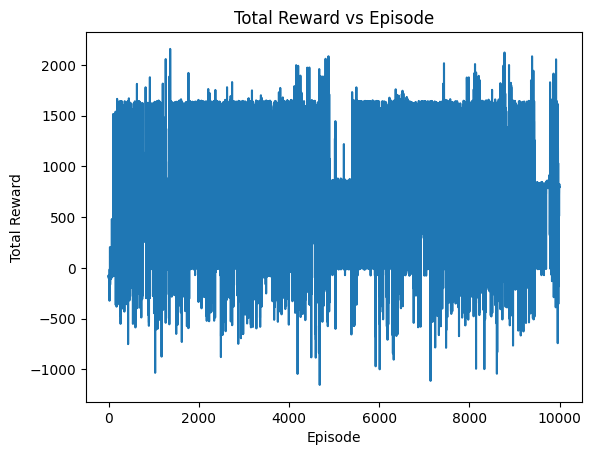

In [11]:
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.show()

In [12]:
color_map = {0: 'white', 1: 'gray', 2: 'red', 3: 'orange'}
def num_to_color(num):
    return color_map[num]

def plot(m_array):    
    # vec_num_to_color = np.vectorize(num_to_color)
    # colored_maze = vec_num_to_color(maze_array)

    cmap = ListedColormap(['white', 'gray', 'red', 'orange', 'blue', 'green'])
    bounds = [0, 1, 2, 3, 4, 5, 6]
    norm = BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(m_array, cmap=cmap, norm=norm, interpolation='none')
    
    # 设置网格线的位置
    ax.set_xticks(np.arange(40) - 0.5, minor=True)
    ax.set_yticks(np.arange(40) - 0.5, minor=True)
    ax.grid(which='minor', color='black', linewidth=1)
    
    ax.set_xticks(range(40))
    ax.set_yticks(range(40))
    ax.tick_params(axis='both', which='both', length=0)
    
    


In [13]:
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def plot(m_array):
    cmap = ListedColormap(['white', 'gray', 'red', 'orange', 'blue', 'green'])
    bounds = [0, 1, 2, 3, 4, 5, 6]
    norm = BoundaryNorm(bounds, cmap.N)
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(m_array, cmap=cmap, norm=norm, interpolation='none')
    
    ax.set_xticks(np.arange(40) - 0.5, minor=True)
    ax.set_yticks(np.arange(40) - 0.5, minor=True)
    ax.grid(which='minor', color='black', linewidth=1)
    
    ax.set_xticks(range(40))
    ax.set_yticks(range(40))
    ax.tick_params(axis='both', which='both', length=0)
    
    ax.axis('off')
    fig.tight_layout(pad=0)
    
    canvas = FigureCanvas(fig)
    canvas.draw()
    
    width, height = fig.get_size_inches() * fig.get_dpi()
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    
    plt.close(fig)
    
    return image

In [14]:
# 生成视频
def generate_video(q_table, output_path, num_episodes=1, max_steps=500):
    maze = Maze()
    frames = []
    
    for episode in range(num_episodes):
        state = maze.reset()
        state_idx = state[0] * maze.cols + state[1]  # 将状态坐标转换为 Q 表格的索引
        
        for step in range(max_steps):
            action = np.argmax(q_table[state_idx])  # 根据 Q 表格选择最优动作
            
            next_state, _, done, _ = maze.step(action)
            next_state_idx = next_state[0] * maze.cols + next_state[1]
            
            now_maze = maze.maze.copy()
            now_maze[maze.agent_pos] = 4
            now_maze[maze.end] = 5
            frame = plot(now_maze)  # 渲染当前迷宫状态为图像帧
            frames.append(frame)
            
            state_idx = next_state_idx
            
            if done:
                print("Happy!")
                break
        

    # 使用 cv2 将帧合成视频文件
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 30, (width, height))

    for frame in frames:
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

    out.release()
    
# q_table, rewards = train()
generate_video(q_table, 'maze_solve.mp4')

Happy!


In [15]:
with open('good_q_table.pkl', 'wb') as f:
    pickle.dump(q_table, f)